In [3]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib  # For saving and loading
import os
import time
os.environ["WANDB_DISABLED"] = "true"

warnings.filterwarnings('ignore')

data_path = './data/IMDB Dataset.csv'
tokenizer_path = './saved_models/tokenizer'
model_path = './saved_models/distilbert_model'
train_data_path = './saved_data/train_dataset.pt'
test_data_path = './saved_data/test_dataset.pt'
logistic_model_path = './saved_models/logistic_model.pkl'
tfidf_path = './saved_models/tfidf.pkl'

os.makedirs('./saved_models', exist_ok=True)
os.makedirs('./saved_data', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

# Load Data
data = pd.read_csv(data_path)
print("Data Shape: ", data.shape)

Data Shape:  (50000, 2)


In [4]:
# # preds = []
# # fine_tune_inference_start = time.time()
# # with torch.no_grad():
# #     for batch in test_loader:

# preds = []
# fine_tune_inference_start = time.time()
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
# fine_tune_inference_time = time.time() - fine_tune_inference_start

# print("Fine-Tuned Model Performance:")
# print(classification_report(test_labels, preds))

# preds = []
# fine_tune_inference_start = time.time()
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
# fine_tune_inference_time = time.time() - fine_tune_inference_start

# print("Fine-Tuned Model Performance:")
# print(classification_report(test_labels, preds))

# preds = []
# fine_tune_inference_start = time.time()
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
# fine_tune_inference_time = time.time() - fine_tune_inference_start

# print("Fine-Tuned Model Performance:")
# print(classification_report(test_labels, preds))
# #         input_ids = batch['input_ids'].to(device)
# #         attention_mask = batch['attention_mask'].to(device)
# #         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
# #         preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
# # fine_tune_inference_time = time.time() - fine_tune_inference_start

# # print("Fine-Tuned Model Performance:")
# # print(classification_report(test_labels, preds))

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained(tokenizer_path)

def preprocess_text(reviews, tokenizer, max_length=128):
    return tokenizer(
        reviews.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

if not os.path.exists(train_data_path) or not os.path.exists(test_data_path):
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        data['review'], data['sentiment'], test_size=0.2, stratify=data['sentiment'], random_state=42
    )

    label_map = {'positive': 1, 'negative': 0}
    train_labels = train_labels.map(label_map).values
    test_labels = test_labels.map(label_map).values

    train_encodings = preprocess_text(train_texts, tokenizer)
    test_encodings = preprocess_text(test_texts, tokenizer)

    torch.save({'encodings': train_encodings, 'labels': train_labels}, train_data_path)
    torch.save({'encodings': test_encodings, 'labels': test_labels}, test_data_path)
else:
    train_data = torch.load(train_data_path)
    test_data = torch.load(test_data_path)
    train_encodings, train_labels = train_data['encodings'], train_data['labels']
    test_encodings, test_labels = test_data['encodings'], test_data['labels']

class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
# if not os.path.exists(model_path):
#     model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     training_args = TrainingArguments(
#         output_dir='./results',
#         num_train_epochs=3,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         warmup_steps=500,
#         weight_decay=0.01,
#         logging_dir='./logs',
#         evaluation_strategy='epoch',
#         logging_steps=10,
#         save_strategy="epoch",
#         fp16=True
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=test_dataset
#     )

#     fine_tune_start = time.time()
#     trainer.train()
#     fine_tune_train_time = time.time() - fine_tune_start
#     model.save_pretrained(model_path)
# else:
#     model = DistilBertForSequenceClassification.from_pretrained(model_path)

# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# preds = []
# fine_tune_inference_start = time.time()
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
# fine_tune_inference_time = time.time() - fine_tune_inference_start

# print("Fine-Tuned Model Performance:")
# print(classification_report(test_labels, preds))

In [7]:
train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [8]:
if not os.path.exists(model_path):
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy='epoch',
        logging_steps=10,
        save_strategy="epoch",
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    fine_tune_start = time.time()
    trainer.train()
    fine_tune_train_time = time.time() - fine_tune_start
    model.save_pretrained(model_path)
else:
    model = DistilBertForSequenceClassification.from_pretrained(model_path)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
fine_tune_inference_start = time.time()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
fine_tune_inference_time = time.time() - fine_tune_inference_start

print("Fine-Tuned Model Performance:")
print(classification_report(test_labels, preds))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.289000,0.287502
2,0.172300,0.291893
3,0.186000,0.462386


Fine-Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [9]:
preds = []
fine_tune_inference_start = time.time()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
fine_tune_inference_time = time.time() - fine_tune_inference_start

print("Fine-Tuned Model Performance:")
print(classification_report(test_labels, preds))

Fine-Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [10]:
base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
base_model.to(device)
base_model.eval()

base_preds = []
base_model_inference_time = time.time()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
        base_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
base_model_inference_time = time.time() - base_model_inference_time

print("Base Model Performance:")
print(classification_report(test_labels, base_preds))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model Performance:
              precision    recall  f1-score   support

           0       0.50      0.96      0.66      5000
           1       0.49      0.03      0.06      5000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.36     10000
weighted avg       0.49      0.50      0.36     10000



In [11]:
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_texts)
X_test = tfidf.transform(test_texts)
clf = LogisticRegression(max_iter=50)

classical_train_time = time.time()
if not os.path.exists(logistic_model_path):
    clf.fit(X_train, train_labels)
    joblib.dump(clf, logistic_model_path)
    joblib.dump(tfidf, tfidf_path)
else:
    clf = joblib.load(logistic_model_path)
    tfidf = joblib.load(tfidf_path)
classical_train_time = time.time() - classical_train_time

classical_inference_time = time.time()

lr_preds = clf.predict(X_test)
classical_inference_time = time.time() - classical_inference_time
print("Classical Machine Learning Model Performance:")
print(classification_report(test_labels, lr_preds))






base_metrics = classification_report(test_labels, base_preds, output_dict=True)
fine_tuned_metrics = classification_report(test_labels, preds, output_dict=True)
classical_metrics = classification_report(test_labels, lr_preds, output_dict=True)

comparison_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision (Class 0)', 'Precision (Class 1)',
        'Recall (Class 0)', 'Recall (Class 1)',
        'F1-Score (Class 0)', 'F1-Score (Class 1)',
        'Training Time (seconds)', 'Inference Time (seconds)'
    ],
    'Base Model': [
        accuracy_score(test_labels, base_preds),
        base_metrics['0']['precision'],
        base_metrics['1']['precision'],
        base_metrics['0']['recall'],
        base_metrics['1']['recall'],
        base_metrics['0']['f1-score'],
        base_metrics['1']['f1-score'],
        None,  # Training time not applicable for base model
        base_model_inference_time   # Inference time not calculated for base model
    ],
    'Fine-Tuned Model': [
        accuracy_score(test_labels, preds),
        fine_tuned_metrics['0']['precision'],
        fine_tuned_metrics['1']['precision'],
        fine_tuned_metrics['0']['recall'],
        fine_tuned_metrics['1']['recall'],
        fine_tuned_metrics['0']['f1-score'],
        fine_tuned_metrics['1']['f1-score'],
        fine_tune_train_time,
        fine_tune_inference_time
    ],
    'Classical Model': [
        accuracy_score(test_labels, lr_preds),
        classical_metrics['0']['precision'],
        classical_metrics['1']['precision'],
        classical_metrics['0']['recall'],
        classical_metrics['1']['recall'],
        classical_metrics['0']['f1-score'],
        classical_metrics['1']['f1-score'],
        classical_train_time,
        classical_inference_time
    ]
})

display(comparison_df)

Classical Machine Learning Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



,Metric,Base Model,Fine-Tuned Model,Classical Model
0,Accuracy,0.499000,0.892200,0.893300
1,Precision (Class 0),0.499482,0.897769,0.897192
2,Precision (Class 1),0.485465,0.886785,0.889483
3,Recall (Class 0),0.964600,0.885200,0.888400
4,Recall (Class 1),0.033400,0.899200,0.898200
5,F1-Score (Class 0),0.658160,0.891440,0.892775
6,F1-Score (Class 1),0.062500,0.892949,0.893820
7,Training Time (seconds),NaN,584.476847,0.765620
8,Inference Time (seconds),34.465810,9.146485,0.003062


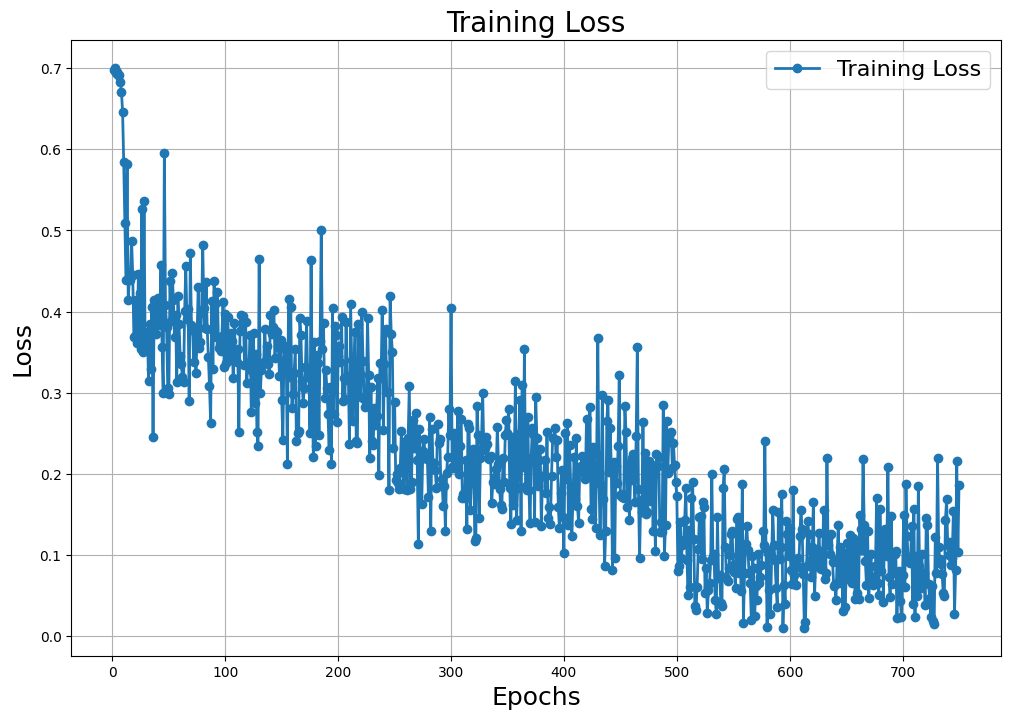

In [12]:
epoch_logs = [log for log in trainer.state.log_history if 'epoch' in log]
train_loss = [log['loss'] for log in epoch_logs if 'loss' in log]

num_epochs = len(train_loss)

plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss', marker='o', linewidth=2)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('Training Loss', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.savefig('./figures/training_validation_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [13]:
# # Fine-Tuned Model Confusion Matrix
# cm_ft = confusion_matrix(test_labels, preds)
# plt.figure()
# plt.imshow(cm_ft, cmap='Blues')
# plt.title("Confusion Matrix: Fine-Tuned Model")
# plt.colorbar()
# plt.xticks([0, 1], ['Negative', 'Positive'])
# plt.yticks([0, 1], ['Negative', 'Positive'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.savefig('./figures/confusion_matrix_fine_tuned_basic.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# # Base Model Confusion Matrix
# cm_base = confusion_matrix(test_labels, base_preds)
# plt.figure()
# plt.imshow(cm_base, cmap='Oranges')
# plt.title("Confusion Matrix: Base Model")
# plt.colorbar()
# plt.xticks([0, 1], ['Negative', 'Positive'])
# plt.yticks([0, 1], ['Negative', 'Positive'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.savefig('./figures/confusion_matrix_base_model_basic.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# # Logistic Regression Confusion Matrix
# cm_lr = confusion_matrix(test_labels, lr_preds)
# plt.figure()
# plt.imshow(cm_lr, cmap='Greens')
# plt.title("Confusion Matrix: Logistic Regression")
# plt.colorbar()
# plt.xticks([0, 1], ['Negative', 'Positive'])
# plt.yticks([0, 1], ['Negative', 'Positive'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.savefig('./figures/confusion_matrix_logistic_regression_basic.pdf', format='pdf', bbox_inches='tight')
# plt.show()


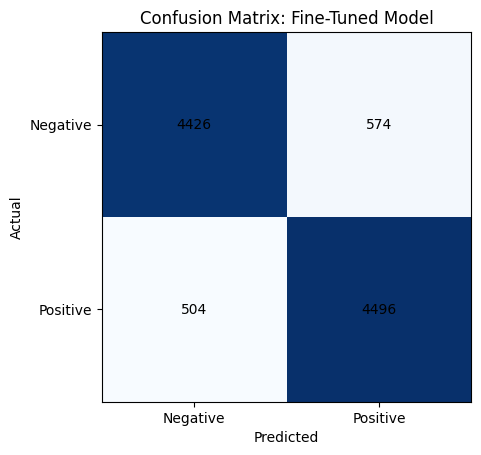

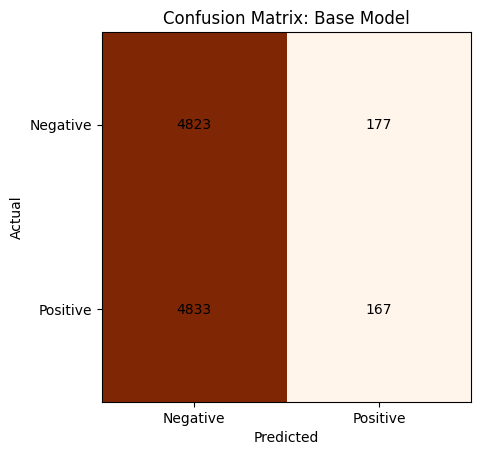

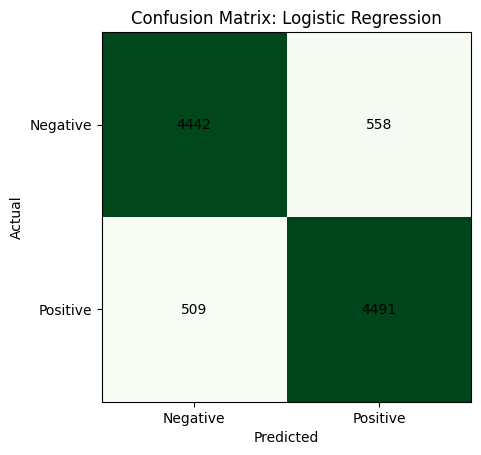

In [14]:
import numpy as np

# Function to add numbers inside the boxes
def plot_confusion_matrix(matrix, title, labels, cmap, save_path):
    plt.figure()
    plt.imshow(matrix, cmap=cmap)
    plt.title(title)
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add text annotations inside the boxes
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

# Fine-Tuned Model Confusion Matrix
cm_ft = confusion_matrix(test_labels, preds)
plot_confusion_matrix(
    cm_ft,
    "Confusion Matrix: Fine-Tuned Model",
    labels=['Negative', 'Positive'],
    cmap='Blues',
    save_path='./figures/confusion_matrix_fine_tuned_basic.pdf'
)

# Base Model Confusion Matrix
cm_base = confusion_matrix(test_labels, base_preds)
plot_confusion_matrix(
    cm_base,
    "Confusion Matrix: Base Model",
    labels=['Negative', 'Positive'],
    cmap='Oranges',
    save_path='./figures/confusion_matrix_base_model_basic.pdf'
)

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(test_labels, lr_preds)
plot_confusion_matrix(
    cm_lr,
    "Confusion Matrix: Logistic Regression",
    labels=['Negative', 'Positive'],
    cmap='Greens',
    save_path='./figures/confusion_matrix_logistic_regression_basic.pdf'
)
